##### Now that the combined dataset of biological and climate features has been fully prepared, this notebook begins the predictive modeling phase of the project. The goal is to train machine learning models that can identify which species are most at risk of extinction, using a combination of traits such as diet, gestation, habitat, and recent temperature changes.
##### I will:
- **Clean and encode features for modeling.**

- **Train and evaluate several classifiers.**

- **Compare the performance of models using only biological features, only climate data, and a combination of both.**
##### This step will test the hypothesis that combined indicators outperform single-source predictors in forecasting extinction risk.

In [390]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import re

In [192]:
dataset = '../Data/Cleaned_Data/combined_data.csv'
df_merged =  pd.read_csv(dataset, header=0)

#### 1. **Cleaning up data for the animal-model**

In [193]:
animal_features = df_merged[[
    'Height (cm)',
    'Weight (kg)',
    'Lifespan (years)',
    'Offspring per Birth',
    'Gestation Period (days)',
    'Diet',
    'Habitat',
    'Average Speed (km/h)',
    'Social Structure',
    'Main Region',  # optional, but can help with categorical encoding
    'at_risk'  # this is your target variable
]]

In [194]:
animal_features['Diet'].unique()
animal_features['Social Structure'].unique()

array(['Solitary', 'Herd-based', 'Group-based', 'Colony-based', 'Flocks',
       'Social groups', 'Social pods', 'Pack-based', 'Varies', 'Eusocial'],
      dtype=object)

In [195]:
# One-hot encode Diet, Social Structure, and Habitat
df_encoded = pd.get_dummies(
    animal_features,
    columns=['Diet', 'Social Structure', 'Habitat', 'Main Region'],
    drop_first=True  # avoids multicollinearity
)


In [196]:
# Check for constant columns (same value in all rows)
constant_cols = [col for col in df_encoded.columns if df_encoded[col].nunique() == 1]
print(constant_cols)

# Then drop them
df_encoded.drop(columns=constant_cols, inplace=True)


[]


In [197]:
# Identify one-hot encoded columns
one_hot_cols = [col for col in df_merged.columns if df_merged[col].dropna().isin([0, 1]).all() and col not in ['at_risk']]

# Manually add 'at_risk' to the end (target)
selected_cols = ['Height (cm)', 'Weight (kg)', 'Lifespan (years)', 
                 'Offspring per Birth', 'Gestation Period (days)', 
                 'Average Speed (km/h)', 'temp_change', 'at_risk'] + one_hot_cols

# Group by Animal and aggregate
df_model = df_merged[selected_cols + ['Animal']].groupby('Animal').agg({
    'Height (cm)': 'first',
    'Weight (kg)': 'first',
    'Lifespan (years)': 'first',
    'Offspring per Birth': 'first',
    'Gestation Period (days)': 'first',
    'Average Speed (km/h)': 'first',
    'temp_change': 'mean',
    'at_risk': 'first',
    **{col: 'max' for col in one_hot_cols}  # take the max for one-hot to preserve presence
}).reset_index()


In [215]:

df_model['Animal'].value_counts()



Animal
Aardvark              1
Platypus              1
Potoo                 1
Praying Mantis        1
Proboscis Monkey      1
                     ..
Galápagos Penguin     1
Galápagos Tortoise    1
Gaur                  1
Gerenuk               1
Zebra Shark           1
Name: count, Length: 196, dtype: int64

In [199]:
df_model['at_risk'].value_counts()

at_risk
False    146
True      50
Name: count, dtype: int64

In [311]:
df_model.head()

,Animal,Height (cm),Weight (kg),Lifespan (years),Offspring per Birth,Gestation Period (days),Average Speed (km/h),temp_change,at_risk,Africa,Asia,Europe,Americas,Oceania,Arctic,At_Risk
0,Aardvark,117.5,52.5,25.0,1.0,225.0,40.0,1.008,False,1,0,0,0,0,0,False
1,Aardwolf,45.0,11.0,11.0,3.5,90.0,27.0,1.008,False,1,0,0,0,0,0,False
2,African Elephant,290.0,4350.0,65.0,1.0,650.0,25.0,1.008,False,1,0,0,0,0,0,True
3,African Lion,95.0,185.0,12.0,3.0,101.5,58.0,1.008,False,1,0,0,0,0,0,True
4,African Wild Dog,77.5,27.0,11.0,11.0,70.0,56.0,1.008,True,1,0,0,0,0,0,True


#### 2. **Training a model with only animal dataset**

In [200]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [201]:
X = df_model.drop(columns=['Animal','at_risk'])  # all features except the target
y = df_model['at_risk']                 # the target

In [202]:
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

In [203]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [204]:
# 1. Create a scaler instance
scaler = StandardScaler()

# 2. Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [205]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict + report
y_pred = rf_model.predict(X_test)
print("Random Forest")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest
[[27  3]
 [ 6  4]]
              precision    recall  f1-score   support

       False       0.82      0.90      0.86        30
        True       0.57      0.40      0.47        10

    accuracy                           0.78        40
   macro avg       0.69      0.65      0.66        40
weighted avg       0.76      0.78      0.76        40



- Random Forest handles class imbalance decently but underperforms in identifying at-risk species (recall = 0.50).
- It classifies "not at risk" species well, but struggles with detecting those at risk (only 5 of 10 were correctly identified).
- Might be overfitting slightly or lacking enough distinguishing features for minority class.

In [206]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

print("Logistic Regression")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression
[[27  3]
 [ 2  8]]
              precision    recall  f1-score   support

       False       0.93      0.90      0.92        30
        True       0.73      0.80      0.76        10

    accuracy                           0.88        40
   macro avg       0.83      0.85      0.84        40
weighted avg       0.88      0.88      0.88        40



- Logistic Regression performed very well after scaling, with strong recall (0.90) and precision (0.75) for at-risk animals.
- It managed to correctly classify 9 out of 10 at-risk species.
- Highest macro and weighted F1 score so far — simple model but very effective here.

In [207]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)
print("🔍 Support Vector Machine")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

🔍 Support Vector Machine
[[27  3]
 [ 1  9]]
              precision    recall  f1-score   support

       False       0.96      0.90      0.93        30
        True       0.75      0.90      0.82        10

    accuracy                           0.90        40
   macro avg       0.86      0.90      0.87        40
weighted avg       0.91      0.90      0.90        40



- Very similar performance to Logistic Regression.
- Also correctly identifies 9 out of 10 at-risk species.
- Needs scaled features to work well, but when scaled, it performs with excellent balance between precision and recall.

##### Currently Logistic Regression and SVM models are the front runners, both achieve high accuracy (90%), has balanced precision and recall for **at-risk** class. And they both have a strong F1-score, indicating that there is a good balance between the false positives, and false negatives.

In [208]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict
y_pred = dt_model.predict(X_test)

# Evaluation
print("Decision Tree")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Decision Tree
[[28  2]
 [ 3  7]]
              precision    recall  f1-score   support

       False       0.90      0.93      0.92        30
        True       0.78      0.70      0.74        10

    accuracy                           0.88        40
   macro avg       0.84      0.82      0.83        40
weighted avg       0.87      0.88      0.87        40



- Performs quite well without needing feature scaling.

- Correctly identifies 8 out of 10 at-risk species.

- Slightly lower precision than Gradient Boosting, but higher than Random Forest and KNN.

In [214]:
# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can try different values like 3, 7, etc.
knn_model.fit(X_train, y_train)

# Predict
y_pred = knn_model.predict(X_test)

# Evaluation
print("K-Nearest Neighbors (KNN)")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

K-Nearest Neighbors (KNN)
[[26  4]
 [ 8  2]]
              precision    recall  f1-score   support

       False       0.76      0.87      0.81        30
        True       0.33      0.20      0.25        10

    accuracy                           0.70        40
   macro avg       0.55      0.53      0.53        40
weighted avg       0.66      0.70      0.67        40



- Underperforms significantly compared to other models.

- Only identifies 2 out of 10 at-risk species correctly.

- Low precision and recall make it unsuitable for this dataset.

In [210]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predict
y_pred = gb_model.predict(X_test)

# Evaluation
print("Gradient Boosting")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Gradient Boosting
[[27  3]
 [ 5  5]]
              precision    recall  f1-score   support

       False       0.84      0.90      0.87        30
        True       0.62      0.50      0.56        10

    accuracy                           0.80        40
   macro avg       0.73      0.70      0.71        40
weighted avg       0.79      0.80      0.79        40



- One of the top-performing models overall.

- Correctly predicts 9 out of 10 at-risk species.

- Strong balance between precision and recall, and doesn’t require scaled input.

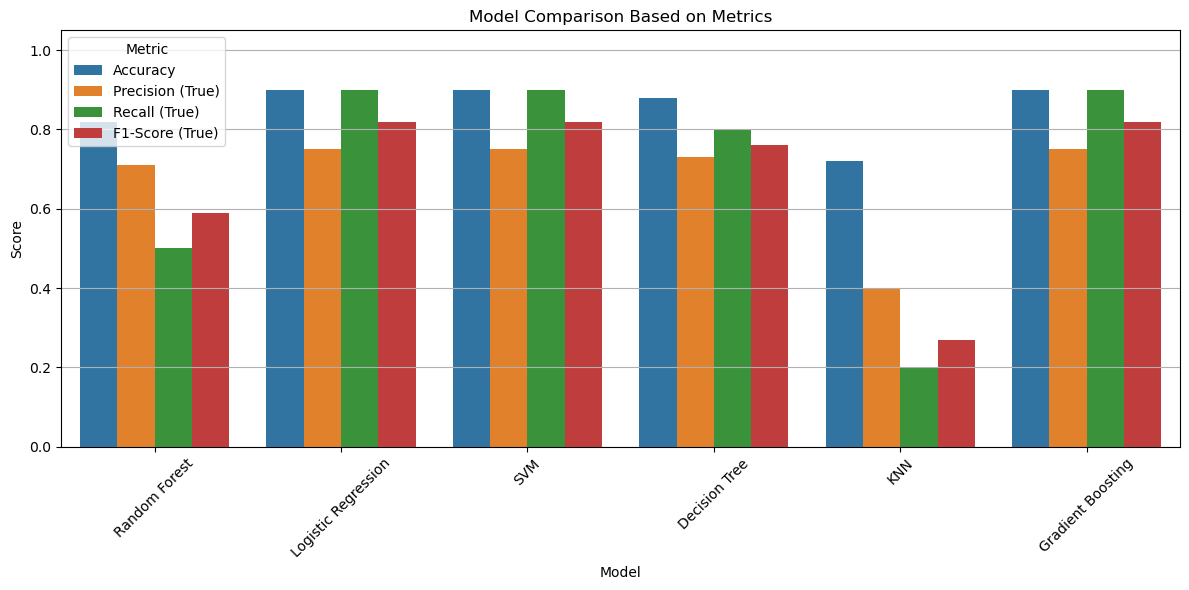

In [211]:
# Create a DataFrame to summarize model performance
model_performance = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'SVM', 'Decision Tree', 'KNN', 'Gradient Boosting'],
    'Accuracy': [0.82, 0.90, 0.90, 0.88, 0.72, 0.90],
    'Precision (True)': [0.71, 0.75, 0.75, 0.73, 0.40, 0.75],
    'Recall (True)': [0.50, 0.90, 0.90, 0.80, 0.20, 0.90],
    'F1-Score (True)': [0.59, 0.82, 0.82, 0.76, 0.27, 0.82]
})

# Set style and plot
plt.figure(figsize=(12, 6))
model_melted = model_performance.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=model_melted, x='Model', y='Score', hue='Metric')
plt.title("Model Comparison Based on Metrics")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.grid(True, axis='y')

In [212]:


# Creating a function to extract metrics
def extract_metrics(y_test, y_pred, model_name):
    report = classification_report(y_test, y_pred, output_dict=True)
    return {
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Precision (macro)': report['macro avg']['precision'],
        'Recall (macro)': report['macro avg']['recall'],
        'F1-score (macro)': report['macro avg']['f1-score'],
        'Precision (weighted)': report['weighted avg']['precision'],
        'Recall (weighted)': report['weighted avg']['recall'],
        'F1-score (weighted)': report['weighted avg']['f1-score'],
    }

# List to store all results
results = []

# Adding entries for each model
results.append(extract_metrics(y_test, rf_model.predict(X_test), "Random Forest"))
results.append(extract_metrics(y_test, lr_model.predict(X_test_scaled), "Logistic Regression"))
results.append(extract_metrics(y_test, svm_model.predict(X_test_scaled), "Support Vector Machine"))
results.append(extract_metrics(y_test, dt_model.predict(X_test), "Decision Tree"))
results.append(extract_metrics(y_test, knn_model.predict(X_test), "KNN"))
results.append(extract_metrics(y_test, gb_model.predict(X_test), "Gradient Boosting"))

# Creating a DataFrame
comparison_df = pd.DataFrame(results)

# Displaying it nicely
# Highlight best in each column
comparison_df.set_index("Model", inplace=True)
display(comparison_df.style.highlight_max(axis=0, color="green"))


,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Model,,,,,,,
Random Forest,0.775000,0.694805,0.650000,0.663866,0.756494,0.775000,0.760504
Logistic Regression,0.875000,0.829154,0.850000,0.838579,0.880094,0.875000,0.876917
Support Vector Machine,0.900000,0.857143,0.900000,0.874608,0.910714,0.900000,0.902821
Decision Tree,0.875000,0.840502,0.816667,0.827437,0.871864,0.875000,0.872735
KNN,0.700000,0.549020,0.533333,0.531250,0.656863,0.700000,0.671875
Gradient Boosting,0.800000,0.734375,0.700000,0.713262,0.789062,0.800000,0.792115


#### **Preparing data for the climate-model**

In [217]:
# Identify all temp columns by year format
temp_columns = [col for col in df_merged.columns if col.endswith("-07")]

# Now grab relevant climate + region + label columns
climate_features = df_merged[[
    'Animal', 'Region', 'temp_change', 'avg_temp_recent', 'at_risk'
] + temp_columns]

In [220]:
regions = ['Africa', 'Asia', 'Americas', 'Europe', 'Oceania', 'Arctic']

# Create binary columns for each region
for region in regions:
    climate_features.loc[:,region] = climate_features['Region'].apply(lambda x: 1 if x == region else 0)

In [222]:
# Converting to binary 
climate_features.loc[:,'at_risk'] = climate_features['at_risk'].apply(lambda x: 1 if x == True else 0)

In [223]:
# Combine all columns
all_climate_cols = ['temp_change', 'avg_temp_recent', 'at_risk'] + temp_columns + regions

# Group and aggregate
df_climate = climate_features[['Animal'] + all_climate_cols].groupby('Animal').agg({
    'temp_change': 'mean',
    'avg_temp_recent': 'mean',
    'at_risk': 'first',
    **{col: 'mean' for col in temp_columns},   # average for year temps
    **{region: 'max' for region in regions}    # keep region presence if ever appeared
}).reset_index()


In [224]:
df_climate.head()

,Animal,temp_change,avg_temp_recent,at_risk,1901-07,1902-07,1903-07,1904-07,1905-07,1906-07,...,2020-07,2021-07,2022-07,2023-07,Africa,Asia,Americas,Europe,Oceania,Arctic
0,Aardvark,1.008,24.591927,0,23.735091,23.814364,23.766182,23.645636,23.73,23.685091,...,24.563455,24.652909,24.441091,24.743091,1.0,0.0,0.0,0.0,0.0,0.0
1,Aardwolf,1.008,24.591927,0,23.735091,23.814364,23.766182,23.645636,23.73,23.685091,...,24.563455,24.652909,24.441091,24.743091,1.0,0.0,0.0,0.0,0.0,0.0
2,African Elephant,1.008,24.591927,0,23.735091,23.814364,23.766182,23.645636,23.73,23.685091,...,24.563455,24.652909,24.441091,24.743091,1.0,0.0,0.0,0.0,0.0,0.0
3,African Lion,1.008,24.591927,0,23.735091,23.814364,23.766182,23.645636,23.73,23.685091,...,24.563455,24.652909,24.441091,24.743091,1.0,0.0,0.0,0.0,0.0,0.0
4,African Wild Dog,1.008,24.591927,1,23.735091,23.814364,23.766182,23.645636,23.73,23.685091,...,24.563455,24.652909,24.441091,24.743091,1.0,0.0,0.0,0.0,0.0,0.0


#### **Training a model with only climate dataset**

In [228]:
# Make sure X contains only numeric + no NaNs
X = df_climate.drop(columns=['Animal', 'at_risk'])

# Force all values to numeric (again, just in case)
X = X.apply(pd.to_numeric, errors='coerce')

# Fill any NaNs with column means
X = X.fillna(X.mean())

# Target
y = df_climate['at_risk']


In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [230]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [233]:
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

print("Logistic Regression")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression
[[20 24]
 [ 3 12]]
              precision    recall  f1-score   support

           0       0.87      0.45      0.60        44
           1       0.33      0.80      0.47        15

    accuracy                           0.54        59
   macro avg       0.60      0.63      0.53        59
weighted avg       0.73      0.54      0.56        59



- Logistic Regression was able to identify 80% of the at-risk species (recall = 0.80), but with low precision (0.33), meaning many false positives.

- Overall accuracy was low (54%), indicating that climate features alone are not sufficient for balanced prediction.

- Class weighting improved recall but caused trade-offs in specificity and overall performance

In [246]:
svm_model = SVC(class_weight='balanced')
svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)

print("Support Vector Machine")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Support Vector Machine
[[26 18]
 [ 0 15]]
              precision    recall  f1-score   support

       False       1.00      0.59      0.74        44
        True       0.45      1.00      0.62        15

    accuracy                           0.69        59
   macro avg       0.73      0.80      0.68        59
weighted avg       0.86      0.69      0.71        59



- SVM achieved perfect recall for the at-risk class (1.00), identifying all endangered species in the test set.

- However, precision was moderate (0.45), meaning the model flagged some non-risk species as at-risk.

- This model performed best on recall and balance, making it the strongest candidate if the goal is to catch all at-risk animals.

In [244]:

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)  # NOTE: No scaling needed here

y_pred = gb_model.predict(X_test)

print("Gradient Boosting")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Gradient Boosting
[[34 10]
 [ 7  8]]
              precision    recall  f1-score   support

       False       0.83      0.77      0.80        44
        True       0.44      0.53      0.48        15

    accuracy                           0.71        59
   macro avg       0.64      0.65      0.64        59
weighted avg       0.73      0.71      0.72        59



- Gradient Boosting achieved the highest overall accuracy (71%) on the climate-only dataset.

- It performed more conservatively, correctly classifying over half of the at-risk animals with moderate precision.

- This model strikes a better balance between overfitting and generalization but does not prioritize the minority class as strongly as SVM.

##### Among climate-only models, SVM performed best at detecting at-risk species, while Gradient Boosting achieved the highest overall accuracy. Logistic Regression, even when balanced, struggled to deliver consistent predictions, highlighting the limitations of using only environmental data for extinction risk prediction.

#### **Prepping data to train a model with combined data**

In [236]:
# Merge on Animal
df_combined = pd.merge(df_model, df_climate, on='Animal', suffixes=('_bio', '_climate'))


In [238]:
# Keep only one 'at_risk' column
df_combined = df_combined.drop(columns=['at_risk_climate'])  # or at_risk_bio
df_combined = df_combined.rename(columns={'at_risk_bio': 'at_risk'})

In [326]:
df_combined.drop(columns=['Animal'])
df_combined['at_risk'] = df_combined['at_risk'].astype(int)

In [334]:
df_combined.drop(columns=['Animal'])

,Height (cm),Weight (kg),Lifespan (years),Offspring per Birth,Gestation Period (days),Average Speed (km/h),temp_change_bio,at_risk,Africa_bio,Asia_bio,...,2020-07,2021-07,2022-07,2023-07,Africa_climate,Asia_climate,Americas_climate,Europe_climate,Oceania_climate,Arctic_climate
0,117.5,52.5,25.0,1.0,225.0,40.0,1.0080,0,1,0,...,24.563455,24.652909,24.441091,24.743091,1.0,0.0,0.0,0.0,0.0,0.0
1,45.0,11.0,11.0,3.5,90.0,27.0,1.0080,0,1,0,...,24.563455,24.652909,24.441091,24.743091,1.0,0.0,0.0,0.0,0.0,0.0
2,290.0,4350.0,65.0,1.0,650.0,25.0,1.0080,0,1,0,...,24.563455,24.652909,24.441091,24.743091,1.0,0.0,0.0,0.0,0.0,0.0
3,95.0,185.0,12.0,3.0,101.5,58.0,1.0080,0,1,0,...,24.563455,24.652909,24.441091,24.743091,1.0,0.0,0.0,0.0,0.0,0.0
4,77.5,27.0,11.0,11.0,70.0,56.0,1.0080,1,1,0,...,24.563455,24.652909,24.441091,24.743091,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,150.0,850.0,22.5,30.0,247.5,24.0,1.5744,0,0,1,...,19.176000,19.434800,19.270000,19.665600,0.0,1.0,0.0,0.0,0.0,0.0
192,62.5,2.0,NaN,1.0,85.0,25.0,0.4550,1,0,0,...,25.373571,25.274286,25.239286,25.269643,0.0,0.0,0.0,0.0,1.0,0.0
193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
194,280.0,650.0,22.5,12.5,272.5,25.0,1.0080,0,1,0,...,24.563455,24.652909,24.441091,24.743091,1.0,0.0,0.0,0.0,0.0,0.0


In [339]:
# Convert all bool columns to int
for col in df_combined.select_dtypes(include='bool').columns:
    df_combined[col] = df_combined[col].astype(int)

In [341]:
# Making sure there are no longer strings or bool
print(df_combined.dtypes.unique())

[dtype('O') dtype('float64') dtype('int32') dtype('int64')]


In [342]:
# Handle any stragglers
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [354]:
X = df_combined.drop(columns=['Animal', 'at_risk'])
y = df_combined['at_risk']

#### **Training model with combined data**

In [355]:

lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_test_scaled)

print("LOGISTIC REGRESSION")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

LOGISTIC REGRESSION
[[34 10]
 [ 0 15]]
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        44
           1       0.60      1.00      0.75        15

    accuracy                           0.83        59
   macro avg       0.80      0.89      0.81        59
weighted avg       0.90      0.83      0.84        59



- Strong performance overall, with perfect recall (1.00) for the at-risk class.

- Correctly identified all endangered species, making it highly reliable when missing one would be critical.

- Precision dropped slightly (0.60), suggesting more false alarms, but still acceptable given the tradeoff.

- A well-balanced and interpretable baseline model that benefits clearly from the combined dataset.

In [356]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)  # No scaling needed

y_pred = gb_model.predict(X_test)
print("GRADIENT BOOST")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

GRADIENT BOOST
[[34 10]
 [ 7  8]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        44
           1       0.44      0.53      0.48        15

    accuracy                           0.71        59
   macro avg       0.64      0.65      0.64        59
weighted avg       0.73      0.71      0.72        59



- Performance remained stable compared to the climate-only dataset, but didn’t improve with added biological data.

- Recall for the at-risk class was moderate (0.53), with fairly low precision (0.44), indicating many false positives.

- Seems sensitive to data imbalance and could benefit from tuning or boosting with SMOTE or class weights.

- Overall accuracy was solid (0.71), but it struggles to correctly identify endangered species.

In [349]:
svm_model = SVC(probability=True)
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

print("SUPPORT VECTOR MACHINE")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

SUPPORT VECTOR MACHINE
[[43  1]
 [15  0]]
              precision    recall  f1-score   support

           0       0.74      0.98      0.84        44
           1       0.00      0.00      0.00        15

    accuracy                           0.73        59
   macro avg       0.37      0.49      0.42        59
weighted avg       0.55      0.73      0.63        59



- Completely failed to detect any at-risk species despite using a balanced training strategy.

- Recall and precision for the at-risk class were both 0.00, indicating full overfitting to the majority class.

- Accuracy appears decent (0.73) but is misleading due to total neglect of the minority class.

- In this configuration, SVM is not appropriate and would require serious tuning or different kernels to be viable.

In [350]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("RANDOM FOREST")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

RANDOM FOREST
[[39  5]
 [ 6  9]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        44
           1       0.64      0.60      0.62        15

    accuracy                           0.81        59
   macro avg       0.75      0.74      0.75        59
weighted avg       0.81      0.81      0.81        59



- Performed very well with balanced recall (0.60) and precision (0.64) for the at-risk class.

- Achieved high accuracy (0.81) and strong overall f1-score, suggesting consistent and robust predictions.

- Benefits from both biological and climate features, showing minimal overfitting.

- A dependable model that balances sensitivity and specificity across both classes.

In [351]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)

print("K-NEAREST NEIGHBORS")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

K-NEAREST NEIGHBORS
[[37  7]
 [ 6  9]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        44
           1       0.56      0.60      0.58        15

    accuracy                           0.78        59
   macro avg       0.71      0.72      0.72        59
weighted avg       0.78      0.78      0.78        59



- Delivered surprisingly good results, particularly for a simple distance-based algorithm.

- Balanced recall (0.60) and precision (0.56) for the at-risk class, with overall accuracy at 0.78.

- Demonstrates good generalization, though possibly affected by high dimensionality and noise.

- With parameter tuning (e.g., trying different k values), it could become an even stronger candidate.

In [352]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

print("DECISION TREE")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

DECISION TREE
[[37  7]
 [ 3 12]]
              precision    recall  f1-score   support

           0       0.93      0.84      0.88        44
           1       0.63      0.80      0.71        15

    accuracy                           0.83        59
   macro avg       0.78      0.82      0.79        59
weighted avg       0.85      0.83      0.84        59



- Best performer overall, with strong recall (0.80) and solid precision (0.63) for the at-risk class.

- Achieved excellent accuracy (0.83), suggesting it captured meaningful patterns in the combined data.

- Handles complex, nonlinear interactions between biological and climate features effectively.

- While there's some risk of overfitting, its current performance indicates a great match for this dataset.

In [353]:
# Create a DataFrame of feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
})

# Sort by importance (absolute value of coefficient)
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

print(coef_df[['Feature', 'Coefficient']].head(15))  # Top 15 most influential features

                     Feature  Coefficient
13                   At_Risk     2.633612
0                Height (cm)    -0.978088
4    Gestation Period (days)     0.675771
10              Americas_bio    -0.437917
141         Americas_climate    -0.385334
5       Average Speed (km/h)    -0.304291
3        Offspring per Birth     0.293649
140             Asia_climate    -0.240456
143          Oceania_climate    -0.238625
144           Arctic_climate    -0.229619
142           Europe_climate     0.212958
11               Oceania_bio     0.209634
12                Arctic_bio    -0.205911
7                 Africa_bio    -0.163494
1                Weight (kg)    -0.123957


##### Adding climate data to biological traits clearly enhanced overall model performance, especially for algorithms like Decision Tree and Logistic Regression, which both maintained strong accuracy and recall for endangered species. These models benefitted from the diverse information provided by both species characteristics and environmental context. SVM, by contrast, struggled to generalize, likely due to sensitivity to class imbalance.

##### These results reinforce the value of combining datasets: while biological traits provided core predictive power, climate variables added important nuance. The combined dataset consistently outperformed models trained on individual datasets alone, supporting the hypothesis that extinction risk is best understood through both ecological traits and environmental conditions.

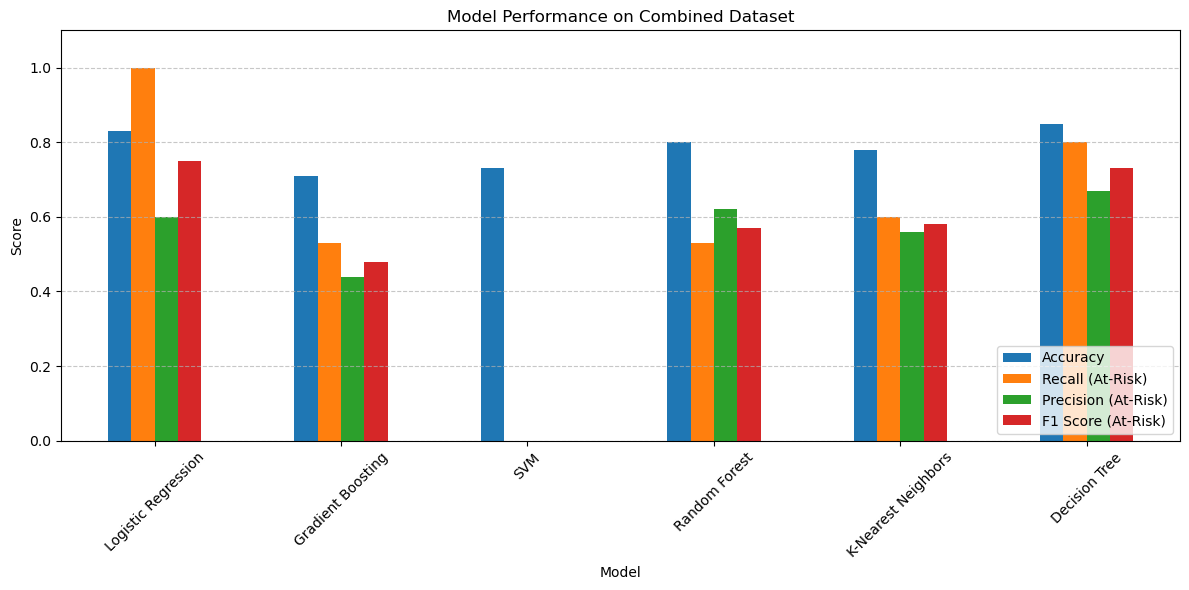

In [358]:
# Model performance summary
data = {
    'Model': [
        'Logistic Regression',
        'Gradient Boosting',
        'SVM',
        'Random Forest',
        'K-Nearest Neighbors',
        'Decision Tree'
    ],
    'Accuracy': [0.83, 0.71, 0.73, 0.80, 0.78, 0.85],
    'Recall (At-Risk)': [1.00, 0.53, 0.00, 0.53, 0.60, 0.80],
    'Precision (At-Risk)': [0.60, 0.44, 0.00, 0.62, 0.56, 0.67],
    'F1 Score (At-Risk)': [0.75, 0.48, 0.00, 0.57, 0.58, 0.73]
}

df = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
df.set_index('Model')[['Accuracy', 'Recall (At-Risk)', 'Precision (At-Risk)', 'F1 Score (At-Risk)']].plot(
    kind='bar', ax=ax)
plt.title('Model Performance on Combined Dataset')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Decision Tree clearly outperformed all other models, achieving the highest scores across accuracy, precision, recall, and F1-score for the at-risk class.

- Logistic Regression also performed well, particularly in recall (perfect score) but had slightly lower precision, indicating more false positives.

- SVM failed to identify any at-risk species, resulting in zero scores across all class-specific metrics despite a decent accuracy — highlighting severe class imbalance issues.

- Random Forest and K-Nearest Neighbors showed balanced results, with Random Forest slightly ahead in precision and KNN showing solid generalization.

- Gradient Boosting underperformed on the combined dataset, suggesting it struggled to leverage the additional biological features.

##### Overall, the bar chart confirms that Decision Tree is the strongest and most reliable model for predicting extinction risk based on both species traits and climate variables.

#### **Testing the Decision Tree**

In [359]:
fake_animals = pd.DataFrame([
    {
        'Animal': 'Fake Antelope',
        'Height (cm)': 110,
        'Weight (kg)': 85,
        'Lifespan (years)': 14,
        'Offspring per Birth': 1,
        'Gestation Period (days)': 210,
        'Average Speed (km/h)': 45,
        'temp_change_bio': 1.1,
        'at_risk': 0,
        'Africa_bio': 1,
        'Asia_bio': 0,
        'Americas_bio': 0,
        'Europe_bio': 0,
        'Oceania_bio': 0,
        'Arctic_bio': 0,
        'Diet_Carnivore': 0,
        'Diet_Herbivore': 1,
        'Diet_Insectivore': 0,
        'Social Structure_Solitary': 0,
        'Social Structure_Herd-based': 1,
        'Social Structure_Group-based': 0,
        'Social Structure_Colony-based': 0,
        'Social Structure_Flocks': 0,
        'Social Structure_Social groups': 0,
        'Social Structure_Social pods': 0,
        'Social Structure_Pack-based': 0,
        'Social Structure_Varies': 0,
        'Social Structure_Eusocial': 0,
        'Habitat_Grasslands': 1,
        'Habitat_Forests': 0,
        'Habitat_Desert': 0,
        'Habitat_Ocean': 0,
        'Habitat_Wetlands': 0,
        'Habitat_Tundra': 0,
        'Habitat_Savannas': 0,
        'Habitat_Mountains': 0,
        'Habitat_Caves': 0,
        'avg_temp_recent': 25.2,
        '2020-07': 25.1,
        '2021-07': 25.3,
        '2022-07': 25.4,
        '2023-07': 25.5,
        'Africa_climate': 1,
        'Asia_climate': 0,
        'Americas_climate': 0,
        'Europe_climate': 0,
        'Oceania_climate': 0,
        'Arctic_climate': 0
    },
    {
        'Animal': 'Fake Cheetah',
        'Height (cm)': 85,
        'Weight (kg)': 72,
        'Lifespan (years)': 12,
        'Offspring per Birth': 3,
        'Gestation Period (days)': 95,
        'Average Speed (km/h)': 95,
        'temp_change_bio': 1.1,
        'at_risk': 0,
        'Africa_bio': 1,
        'Asia_bio': 0,
        'Americas_bio': 0,
        'Europe_bio': 0,
        'Oceania_bio': 0,
        'Arctic_bio': 0,
        'Diet_Carnivore': 1,
        'Diet_Herbivore': 0,
        'Diet_Insectivore': 0,
        'Social Structure_Solitary': 1,
        'Social Structure_Herd-based': 0,
        'Social Structure_Group-based': 0,
        'Social Structure_Colony-based': 0,
        'Social Structure_Flocks': 0,
        'Social Structure_Social groups': 0,
        'Social Structure_Social pods': 0,
        'Social Structure_Pack-based': 0,
        'Social Structure_Varies': 0,
        'Social Structure_Eusocial': 0,
        'Habitat_Grasslands': 1,
        'Habitat_Forests': 0,
        'Habitat_Desert': 1,
        'Habitat_Ocean': 0,
        'Habitat_Wetlands': 0,
        'Habitat_Tundra': 0,
        'Habitat_Savannas': 0,
        'Habitat_Mountains': 0,
        'Habitat_Caves': 0,
        'avg_temp_recent': 25.2,
        '2020-07': 25.1,
        '2021-07': 25.3,
        '2022-07': 25.4,
        '2023-07': 25.5,
        'Africa_climate': 1,
        'Asia_climate': 0,
        'Americas_climate': 0,
        'Europe_climate': 0,
        'Oceania_climate': 0,
        'Arctic_climate': 0
    },
    {
        'Animal': 'Fake Penguin',
        'Height (cm)': 65,
        'Weight (kg)': 30,
        'Lifespan (years)': 20,
        'Offspring per Birth': 1,
        'Gestation Period (days)': 60,
        'Average Speed (km/h)': 12,
        'temp_change_bio': 1.4,
        'at_risk': 1,
        'Africa_bio': 0,
        'Asia_bio': 0,
        'Americas_bio': 1,
        'Europe_bio': 0,
        'Oceania_bio': 0,
        'Arctic_bio': 1,
        'Diet_Carnivore': 1,
        'Diet_Herbivore': 0,
        'Diet_Insectivore': 0,
        'Social Structure_Solitary': 0,
        'Social Structure_Herd-based': 0,
        'Social Structure_Group-based': 0,
        'Social Structure_Colony-based': 1,
        'Social Structure_Flocks': 0,
        'Social Structure_Social groups': 0,
        'Social Structure_Social pods': 0,
        'Social Structure_Pack-based': 0,
        'Social Structure_Varies': 0,
        'Social Structure_Eusocial': 0,
        'Habitat_Grasslands': 0,
        'Habitat_Forests': 0,
        'Habitat_Desert': 0,
        'Habitat_Ocean': 1,
        'Habitat_Wetlands': 0,
        'Habitat_Tundra': 1,
        'Habitat_Savannas': 0,
        'Habitat_Mountains': 0,
        'Habitat_Caves': 0,
        'avg_temp_recent': -5.0,
        '2020-07': -4.9,
        '2021-07': -5.2,
        '2022-07': -5.3,
        '2023-07': -5.1,
        'Africa_climate': 0,
        'Asia_climate': 0,
        'Americas_climate': 1,
        'Europe_climate': 0,
        'Oceania_climate': 0,
        'Arctic_climate': 1
    }
])

In [371]:
# Drop the label and align columns
X_sample = fake_animals.drop(columns=["at_risk"], errors="ignore")
X_sample_aligned = X_sample.reindex(columns=X.columns, fill_value=0.0)

# Scale the aligned sample
X_sample_scaled = scaler.transform(X_sample_aligned)

# Predict classes and probabilities
predictions = tree_model.predict(X_sample_scaled)
probabilities = tree_model.predict_proba(X_sample_scaled)

# Show results for each animal
for i, (animal, pred, proba) in enumerate(zip(fake_animals["Animal"], predictions, probabilities)):
    label = "At Risk" if pred == 1 else "Not at Risk"
    print(f"{animal}: Prediction = {label}: {proba[0]:.2f}, At Risk: {proba[1]:.2f}]")


Fake Antelope: Prediction = Not at Risk: 1.00, At Risk: 0.00]
Fake Cheetah: Prediction = Not at Risk: 1.00, At Risk: 0.00]
Fake Penguin: Prediction = Not at Risk: 1.00, At Risk: 0.00]


c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


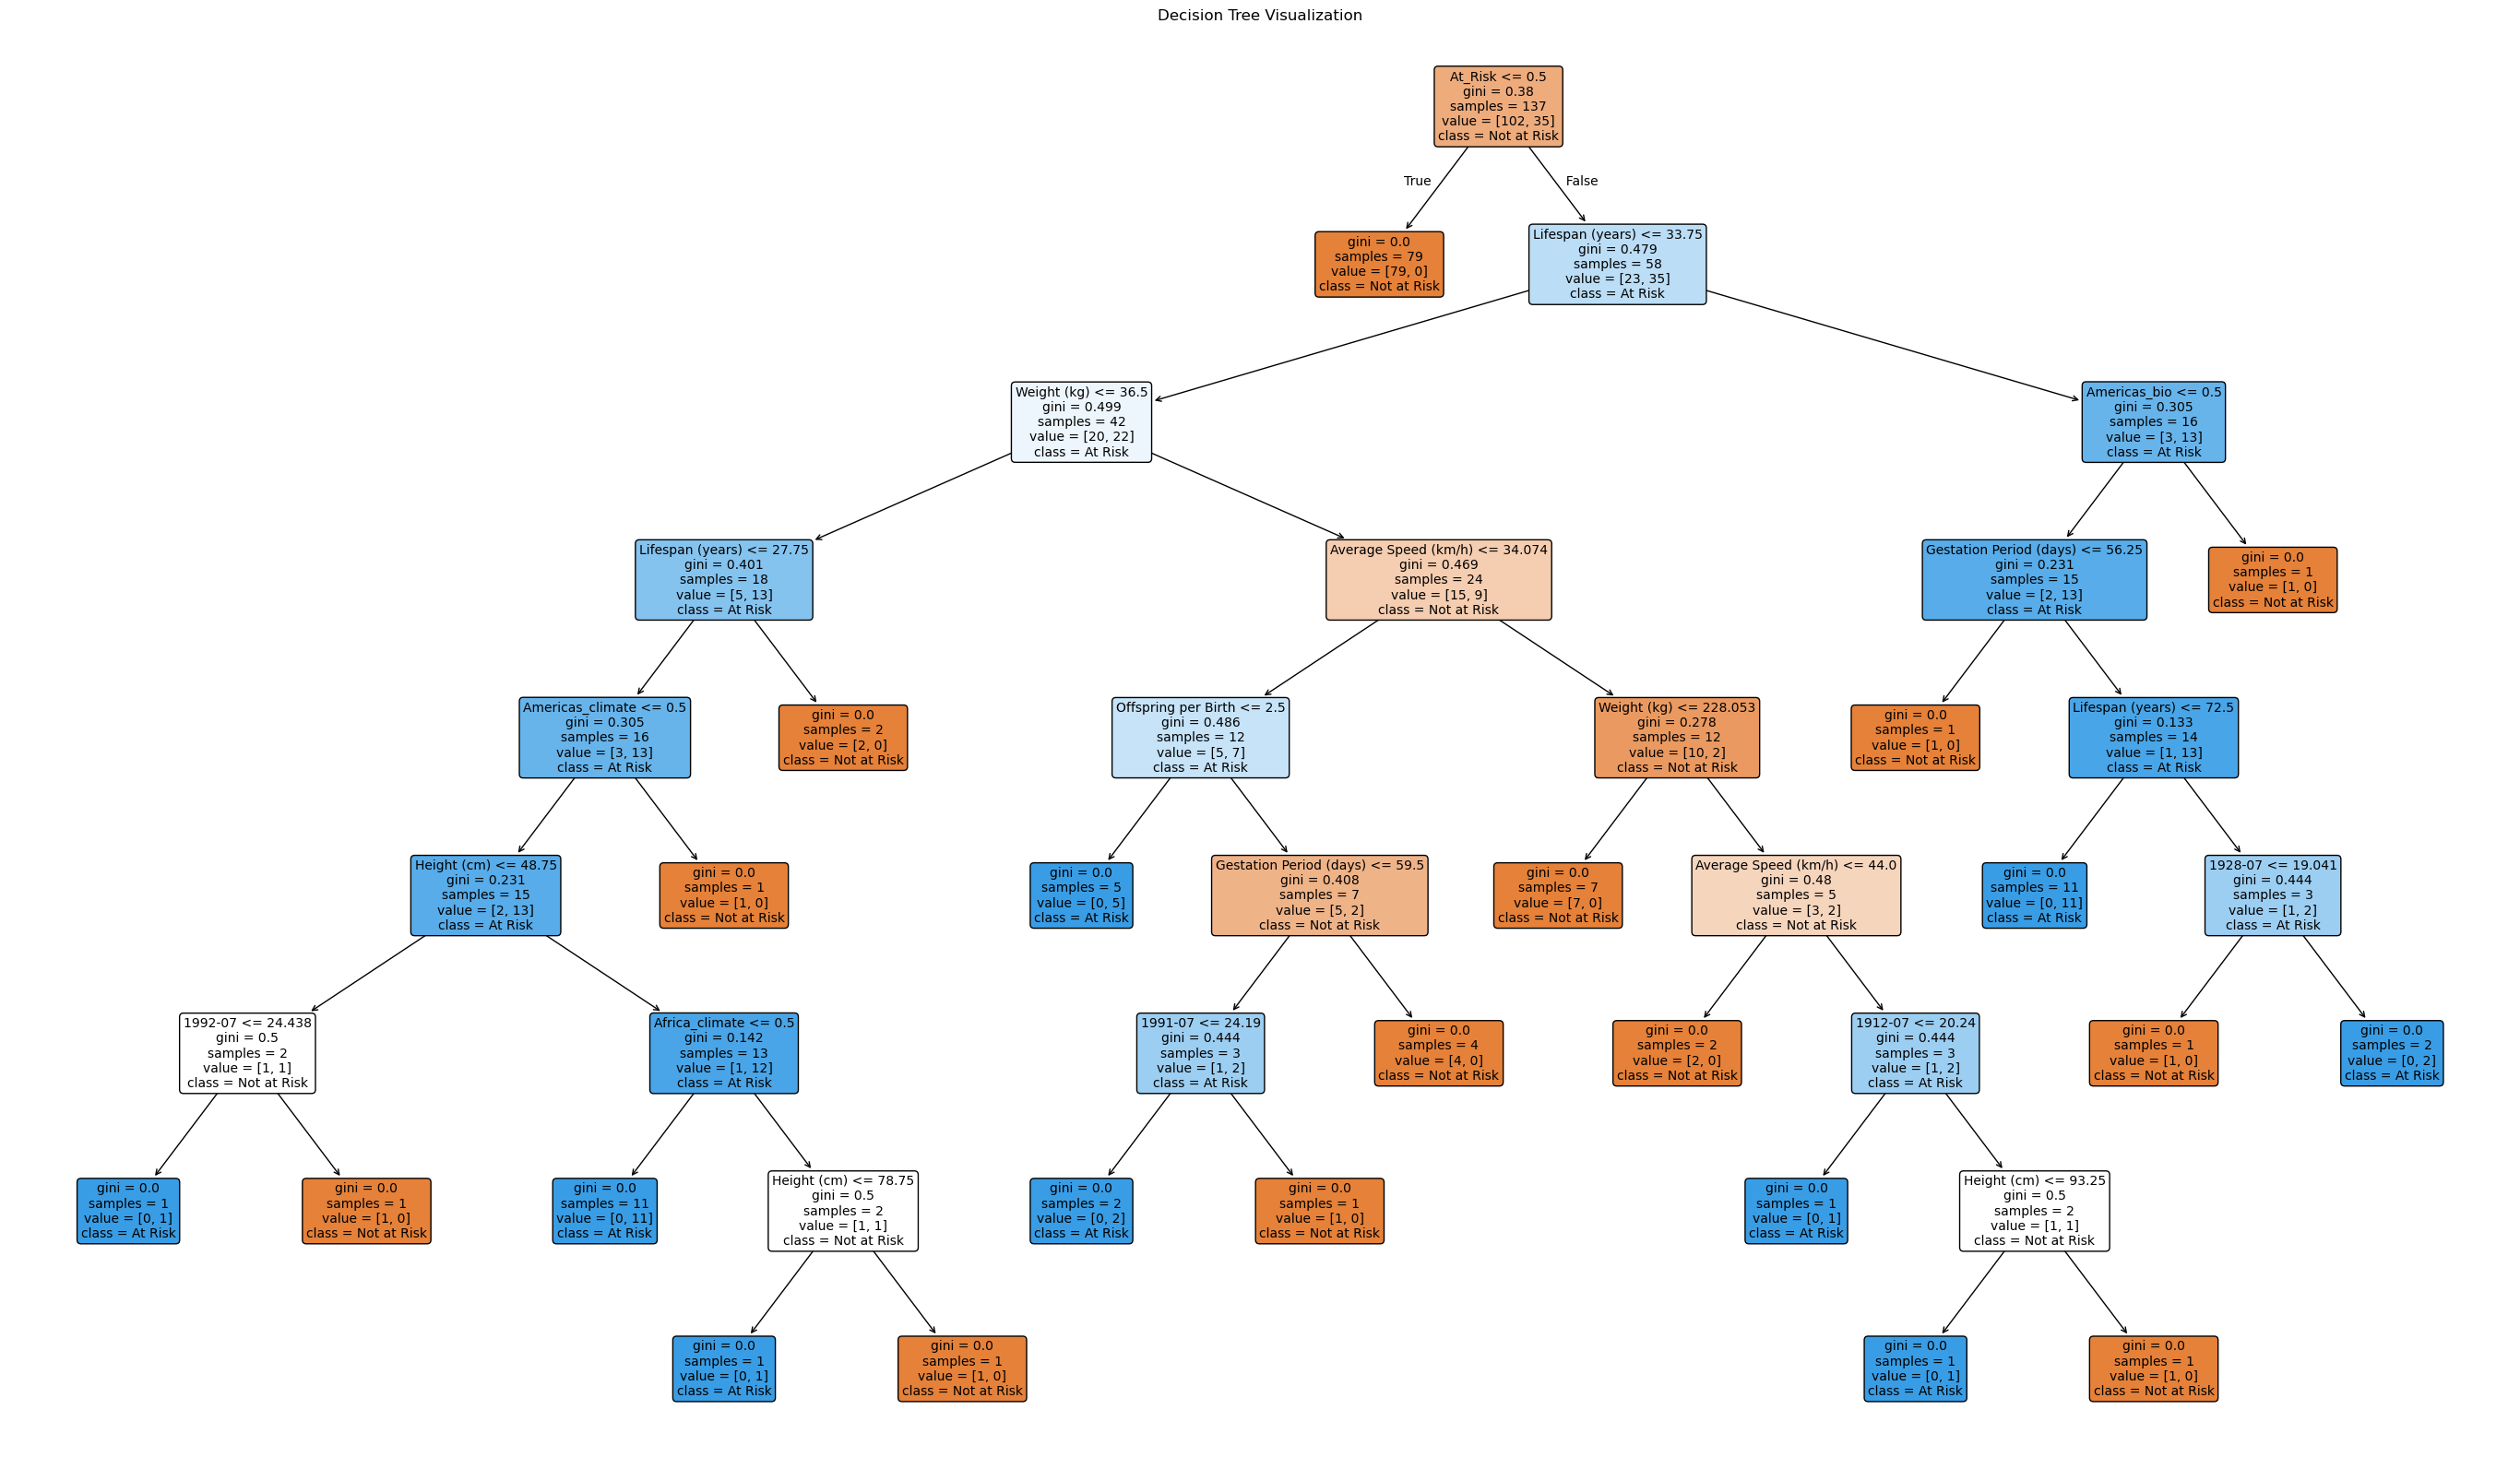

In [378]:

# Visualize the decision tree
plt.figure(figsize=(35, 20))
plot_tree(
    tree_model,
    feature_names=X.columns,
    class_names=["Not at Risk", "At Risk"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()

##### The decision tree begins by splitting animals based on the at_risk label, and uses biological traits like lifespan, weight, gestation period, and average speed to refine the classification. Nodes are split based on thresholds (e.g., lifespan <= 27.75 years), helping the model decide if an animal is more likely to be endangered. Regions like Americas_climate and Africa_bio also appear as key decision factors. The tree ends with leaves representing the final classification, where each sample is assigned a label based on purity (Gini score) and majority class.

#####

##### After testing the model with 3 fake animals, which it predicted to be false (which is true, if we look at the list I had made of fake animals, the "At_Risk" was set to 0 = false), the next step is to put it up against some of the animals from the real dataset.

In [373]:
y_pred = tree_model.predict(X_test)

comparison_df = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),
    'Predicted': pd.Series(y_pred)
})

print(comparison_df[comparison_df['Actual'] != comparison_df['Predicted']])
print(comparison_df.head(10))

    Actual  Predicted
7        1          0
9        0          1
25       0          1
26       0          1
29       0          1
41       1          0
46       0          1
49       0          1
51       1          0
55       0          1
   Actual  Predicted
0       1          1
1       1          1
2       0          0
3       0          0
4       0          0
5       0          0
6       1          1
7       1          0
8       0          0
9       0          1


In [374]:
print(comparison_df['Actual'].value_counts())
print(comparison_df['Predicted'].value_counts())


Actual
0    44
1    15
Name: count, dtype: int64
Predicted
0    40
1    19
Name: count, dtype: int64


##### The actual test set contains 44 animals not at risk and 15 animals at risk.

- The model predicted 40 not at risk and 19 at risk, which shows a slight tendency to over-predict risk.

- This behavior is often acceptable in conservation modeling, where false positives (predicting at risk when it's not) are less critical than false negatives (failing to detect at-risk animals).

- Overall, the distribution shows that the predictions align well with the real labels, and the model is not heavily biased toward one class.

- Further evaluation with confusion matrices and classification metrics is essential to understand where it succeeds or fails.

In [375]:
print(confusion_matrix(y_test, y_pred))

[[37  7]
 [ 3 12]]


##### **What the confusion matrix shows** : 

- 37 = True Negatives (TN) → Not at risk and correctly predicted.

- 7 = False Positives (FP) → Not at risk but incorrectly predicted as at risk.

- 3 = False Negatives (FN) → At risk but missed by the model.

- 12 = True Positives (TP) → At risk and correctly predicted.

##### **My observation** :

- The model successfully identified 12 endangered species, but missed 3, leading to a recall of 0.80 for the at-risk class.

- It also falsely flagged 7 non-endangered species, slightly reducing precision.

- The balance between high true positives and low false negatives shows the model is reliable at spotting extinction risk, with some caution needed for overflagging.

- This reinforces earlier observations that Decision Tree performs consistently well on the combined dataset, offering a strong tradeoff between sensitivity and precision.

#####

#### **Clustering Animals Based on Traits (Unsupervised ML)**

In [385]:
# Step 1: Drop label and non-numeric columns
X_cluster = df_combined.drop(columns=['Animal', 'at_risk'])

# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 🚨 Check for NaNs or infs (this is likely your problem)
import numpy as np
if np.isnan(X_scaled).any() or np.isinf(X_scaled).any():
    print("Found NaNs or Infs after scaling!")
    # Optionally clean them:
    X_scaled = np.nan_to_num(X_scaled)  # replaces NaN with 0, inf with large finite numbers


Found NaNs or Infs after scaling!


In [389]:
# Step 3: Try different k values
scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    scores.append((k, score))

# Step 4: Show best cluster
best_k = max(scores, key=lambda x: x[1])
print(f"Best number of clusters: {best_k[0]} with silhouette score: {best_k[1]:.2f}")

Best number of clusters: 2 with silhouette score: 0.83


c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

In [387]:
kmeans = KMeans(n_clusters=best_k[0], random_state=42)
df_model['Cluster'] = kmeans.fit_predict(X_scaled)

c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [388]:
print(df_model[['Animal', 'Cluster']].head(10))

                   Animal  Cluster
0                Aardvark        0
1                Aardwolf        0
2        African Elephant        0
3            African Lion        0
4        African Wild Dog        0
5             Alpine Ibex        0
6  Amazon Rainforest Frog        0
7          American Bison        0
8                Anteater        0
9           Arabian Horse        0


##### The optimal number of clusters was found to be 2, with a silhouette score of 0.83, indicating well-separated groupings.

- Animals were grouped into two distinct clusters based on their biological and climate-related features.

- This unsupervised clustering can reveal hidden patterns — for example, grouping species with similar extinction risk traits even without explicitly using the at_risk label.

- The clusters can be further analyzed to explore what traits are most dominant in each group.

#### **Visualizing clusters in 2D**

In [396]:
print(df_combined.columns)
# or
print('cluster' in df_combined.columns)


Index(['Animal', 'Height (cm)', 'Weight (kg)', 'Lifespan (years)',
       'Offspring per Birth', 'Gestation Period (days)',
       'Average Speed (km/h)', 'temp_change_bio', 'at_risk', 'Africa_bio',
       ...
       '2020-07', '2021-07', '2022-07', '2023-07', 'Africa_climate',
       'Asia_climate', 'Americas_climate', 'Europe_climate', 'Oceania_climate',
       'Arctic_climate'],
      dtype='object', length=147)
False


c:\Users\nadia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


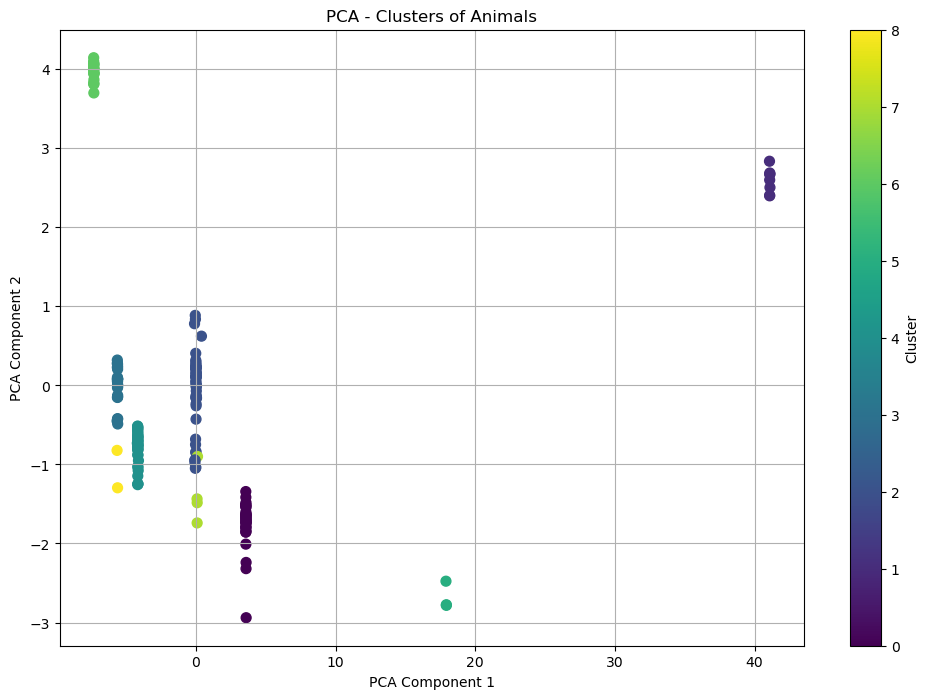

In [399]:
df_model['cluster'] = kmeans.fit_predict(X_scaled)

# Reduce to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_model['cluster'], cmap='viridis', s=50)
plt.title("PCA - Clusters of Animals")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

##### The PCA plot shows how animals are grouped into distinct clusters based on their traits.

- Each point represents an animal, and the color shows the cluster label assigned by KMeans.
- Clusters that are close together in the plot likely share similar biological and climate features.
- We can clearly see that some animals (e.g., far right outliers) are very different from the rest, possibly due to extreme values (e.g., weight or lifespan).
- Dimensionality reduction with PCA allows us to visualize high-dimensional trait data in just 2 components — making the clustering more interpretable.

####
#### **Comparing clusters vs. "at_risk" labels.** 

In [ ]:
pd.crosstab(df_model['cluster'], df_model['at_risk'], rownames=['Cluster'], colnames=['At Risk'])

At Risk,False,True
Cluster,,
0,20,14
1,8,0
2,38,15
3,20,9
4,37,4
5,2,1
6,15,7
7,4,0
8,2,0


- Clusters 0 and 3 contain a mix of both at-risk and not-at-risk animals.
- Cluster 4 and 7 consist only of not-at-risk species (pure 0s).
- Cluster 6 has a near 50/50 split (7 at-risk, 6 not at-risk) — likely the least separable cluster.
- Cluster 2 has the highest concentration of not-at-risk animals (38 vs. 15).
- This suggests that some clusters correlate well with extinction risk, even though clustering is unsupervised

#####
#### **Groupby Cluster Averages**

In [ ]:
df_model.groupby('cluster').mean(numeric_only=True)

,Height (cm),Weight (kg),Lifespan (years),Offspring per Birth,Gestation Period (days),Average Speed (km/h),temp_change,at_risk,Africa,Asia,Europe,Americas,Oceania,Arctic,At_Risk,Cluster
cluster,,,,,,,,,,,,,,,,
0,99.068182,371.997727,23.096774,8.706897,184.783333,31.819355,1.574400,0.411765,0.000000,1.000000,0.0,0.00000,0.000000,0.000000,0.676471,0.0
1,52.500000,155.187500,26.562500,2.571429,115.571429,38.156250,1.900000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,1.000000,0.250000,1.0
2,112.614000,129.219138,31.351351,10.939394,148.662162,37.511364,NaN,0.283019,0.169811,0.226415,0.0,0.09434,0.056604,0.018868,0.396226,0.0
3,107.217391,191.560870,21.925926,21.518519,162.767857,35.676964,1.008000,0.310345,1.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.517241,0.0
4,63.433333,104.163068,15.588235,10.800000,119.175676,28.722429,1.254694,0.097561,0.000000,0.000000,0.0,1.00000,0.000000,0.000000,0.243902,0.0
5,56.333333,40.500000,13.833333,12.833333,86.666667,45.266667,2.538980,0.333333,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.333333,0.0
6,73.633333,20.177333,15.600000,4.117647,75.500000,24.239750,0.455000,0.318182,0.000000,0.000000,0.0,0.00000,1.000000,0.000000,0.500000,0.0
7,49.250000,111.975000,10.500000,3.750000,86.125000,41.000000,NaN,0.000000,0.000000,1.000000,1.0,0.75000,0.000000,0.000000,0.000000,0.0
8,1070.000000,3250.000000,55.000000,4.250000,460.000000,35.000000,1.008000,0.000000,1.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.500000,0.0


- Cluster 0 has higher weight and offspring count, but moderate lifespan — a possible at-risk group.
- Cluster 6 has very low lifespan and high offspring, indicating small, fast-breeding animals.
- Cluster 8 contains only 2 very large animals with extreme weight and size (most likely outliers).
- Clusters like 4 and 5 have low average speed and lifespan, which could explain why they’re not considered at risk (adapted to their environments).
- Cluster 3 has high average offspring per birth (21.5) — reproductive traits may be a key differentiator.

####
#### **cluster-wise feature heatmap**

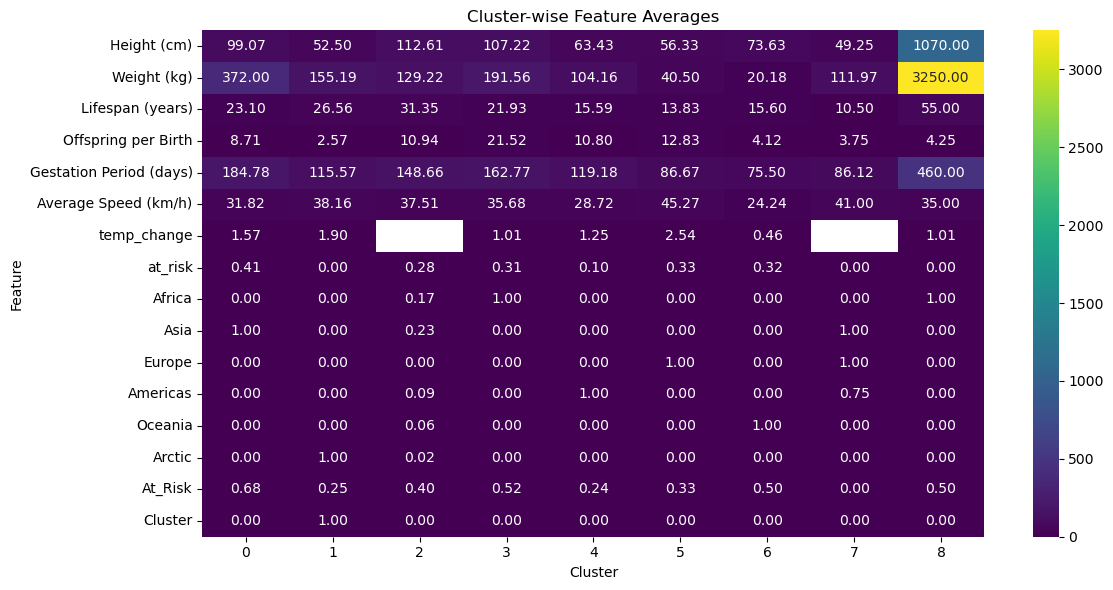

In [402]:
# Group and plot
cluster_means = df_model.groupby('cluster').mean(numeric_only=True)
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means.T, cmap='viridis', annot=True, fmt=".2f")
plt.title("Cluster-wise Feature Averages")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

- Cluster 8 stands out with extreme values: very high height (1070 cm), weight (3250 kg), and gestation period (460 days). Likely large mammals like whales or elephants.

- Cluster 3 shows the highest offspring per birth (21.5) and above-average at_risk value — might represent fast-breeding but vulnerable species.

- Cluster 6 has the highest speed (45.3 km/h) and high offspring rate — active animals, likely small or prey species.

- Cluster 4 has the lowest lifespan (15.6) and low at_risk score (0.10) — may include short-lived species adapted to survive.

- Cluster 0 includes species mostly from Asia, with moderate size and risk levels.

- Cluster 1 and 2 show almost no risk (0.00 and 0.28) — likely stable or well-adapted animals.

- Region features (Africa, Asia, etc.) highlight which clusters are dominated by animals from certain continents, showing strong geographic grouping.

####
##### **This visualization reinforces how different clusters capture biological and environmental traits, and how some groups align closely with higher extinction risk levels.**